In [47]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf

In [48]:
aapl = yf.Ticker('AAPL')
time = '3y'

data = aapl.history(period = time)

data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,751.000000,751.000000,751.000000,751.000000,7.510000e+02,751.000000,751.0
mean,196.280058,198.310334,194.478423,196.503449,5.837990e+07,0.003955,0.0
std,32.905830,33.159792,32.603483,32.922990,2.475685e+07,0.031077,0.0
min,124.137239,125.871086,122.324586,123.161957,2.323470e+07,0.000000,0.0
25%,172.056255,174.237792,171.069048,172.229843,4.443860e+07,0.000000,0.0
50%,192.335278,193.674569,190.461295,192.076050,5.224280e+07,0.000000,0.0
75%,223.749404,225.953236,221.782735,224.456779,6.556255e+07,0.000000,0.0
max,276.721738,277.051436,268.899335,271.137146,3.186799e+08,0.260000,0.0


In [49]:
data.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-11-11 00:00:00-05:00,143.652848,147.780564,142.224386,147.475174,93979700
2022-11-14 00:00:00-05:00,146.756011,148.046539,145.238890,146.076263,73374100
2022-11-15 00:00:00-05:00,149.957698,151.307332,146.352089,147.810089,89868300
2022-11-16 00:00:00-05:00,146.913633,147.642625,145.100967,146.578674,64218300
2022-11-17 00:00:00-05:00,144.253731,149.228680,143.977893,148.479980,80389400


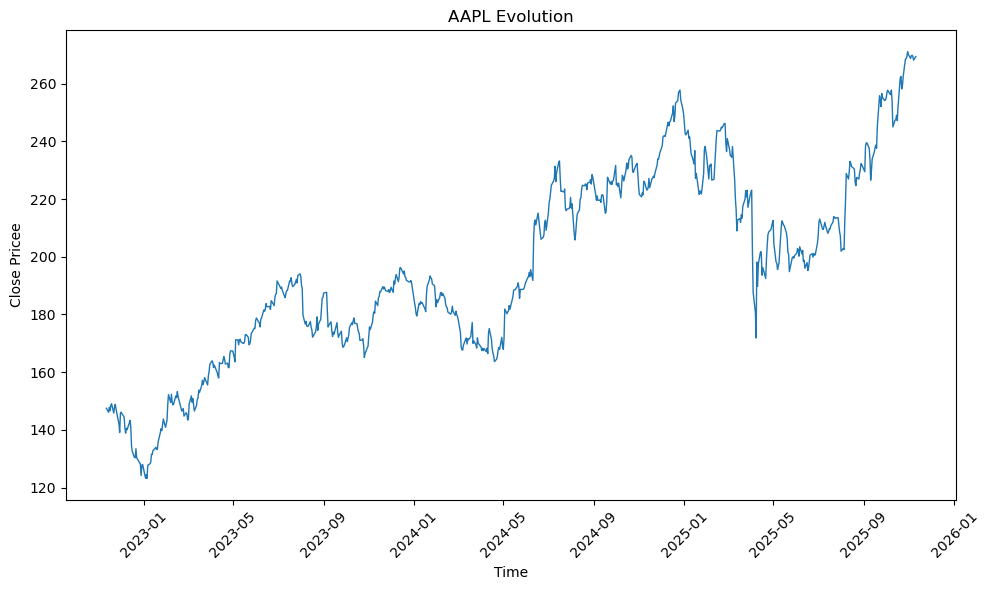

In [50]:
fig, ax = plt.subplots(1,1, figsize = (10,6), dpi = 100)

plt.plot(data.index, data['Close'], linewidth = 1, label = 'Time evolution AAPL')

plt.xticks(rotation = 45)
plt.xlabel('Time')
plt.ylabel('Close Pricee')
plt.title('AAPL Evolution')
plt.tight_layout()
plt.savefig('../figures/stock_figs/aapl.png', dpi = 100)
plt.show()

In [51]:
data_new = yf.download('AAPL', start="2022-11-11", end="2025-11-10")
data_new

/var/folders/f8/0hzmswyj0sn232kss0n40r_80000gn/T/ipykernel_32220/3173593836.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_new = yf.download('AAPL', start="2022-11-11", end="2025-11-10")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2022-11-11,147.475159,147.780549,142.224371,143.652833,93979700
2022-11-14,146.076248,148.046524,145.238875,146.755996,73374100
2022-11-15,147.810089,151.307332,146.352089,149.957698,89868300
2022-11-16,146.578659,147.642610,145.100952,146.913617,64218300
2022-11-17,148.479996,149.228695,143.977908,144.253745,80389400
...,...,...,...,...,...
2025-11-03,268.789429,270.587704,265.992153,270.158128,50194600
2025-11-04,269.778473,271.227050,267.360803,268.070107,49274800


In [52]:
num_sim = 20
forecast_days = 200

simulations = np.zeros((num_sim, forecast_days))

last_price = data['Close'].iloc[-1]

daily_returns = data['Close'].pct_change().dropna()

In [53]:
for i in range(num_sim):
    cum_ret = np.random.choice(daily_returns, size = forecast_days, replace = True).cumsum()
    simulations[i, : ] = last_price*(1+cum_ret) # converts the percentage change back to the real price 

    #print(simulations)

In [54]:
print(simulations[2, 0:4])

[275.36601378 272.6927519  273.98411264 282.7596122 ]


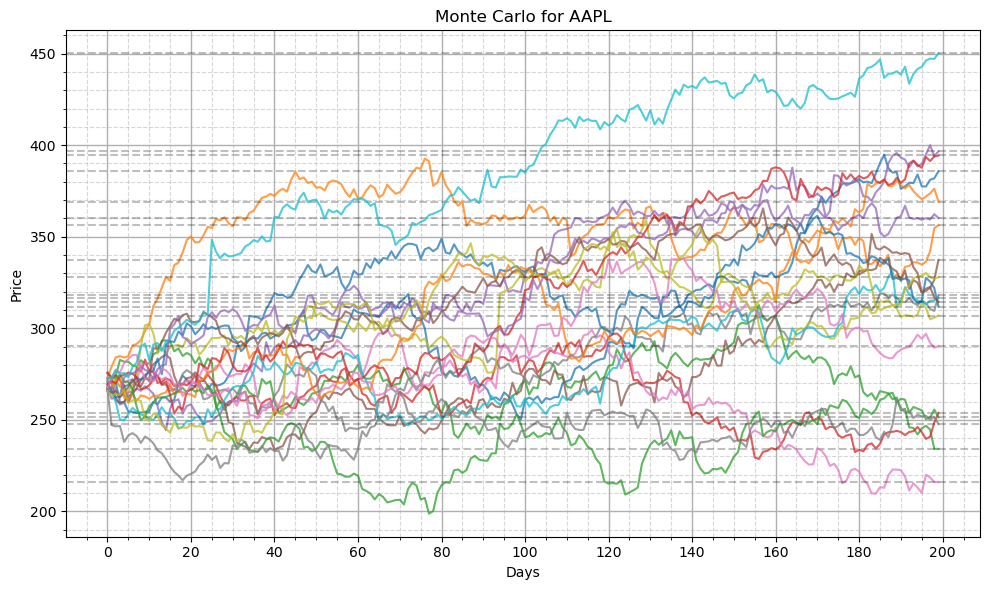

In [55]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(num_sim):
    ax.plot(simulations[i, :], alpha=0.75)
    ax.axhline(simulations[i, -1], linestyle='--', color='black', alpha=0.25)

ax.set_title('Monte Carlo for AAPL')
ax.set_xlabel('Days')
ax.set_ylabel('Price')

ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(10))

ax.grid(which="major", linewidth=1)
ax.grid(which="minor", linestyle="--", alpha=0.5)

fig.tight_layout()

plt.savefig('../figures/stock_figs/mc_sim.png', dpi = 100)
plt.show()
